In [1]:
#load the mnist dataset 
from keras.datasets import mnist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from math import ceil





In [2]:
# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Download and load training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_batch_size = 100

# Create data loaders for training and test datasets
train_loader = DataLoader(train_dataset, train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
#number of batches in the loaders
print(len(train_loader))

600


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(8 * 7 * 7, 16)  # Input is 64 channels * 7x7 feature maps
        self.fc2 = nn.Linear(16, 10)  # 10 output classes for MNIST digits

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPooling
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPooling
        x = x.view(-1, 8 * 7 * 7)  # Flatten the tensor before feeding into fully connected layers
        x = torch.relu(self.fc1(x))  # Fully connected layer 1
        x = self.fc2(x)  # Fully connected layer 2 (Output)
        return x


In [5]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients during testing
        for images, labels in test_loader:
            # Move tensors to the appropriate device
            images, labels = images, labels

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')
    return 100 * correct / total

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    accuracy_list = []
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        count = 0
        for images, labels in train_loader:
            if count == 200:
                break
            # Move tensors to the appropriate device
            images, labels = images, labels

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
            count += 1

        print(f"Training on Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

        accuracy_list.append(test_model(model, test_loader))
    return accuracy_list
        



In [6]:
def display_confusion_matrix(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to compute gradients during testing
        for images, labels in test_loader:
            # Move tensors to the appropriate device
            images, labels = images, labels

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.tolist())
            actuals.extend(labels.tolist())

    # Display a confusion matrix
    cm = confusion_matrix(actuals, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    

## - COSGD

In [7]:
def create_cluster_dataloaders(dataset, cluster_batch_size):
    """
    Create a DataLoader for each cluster (digit) in the dataset.
    """
    cluster_dataloaders = []
    for digit in range(10):
        indices = [i for i, label in enumerate(dataset.targets) if label == digit]
        cluster_subset = Subset(dataset, indices)
        dataloader = DataLoader(cluster_subset, batch_size=cluster_batch_size, shuffle=True)
        cluster_dataloaders.append(dataloader)
    return cluster_dataloaders


In [14]:
def zero_gradients(model):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.zero_()

def get_gradients(model):
    return [param.grad.clone() for param in model.parameters() if param.requires_grad]

def set_gradients(model, gradients):
    for param, grad in zip(model.parameters(), gradients):
        param.grad = grad.clone()

def orthogonalize_gradients(model, gradients_list):
    # Flatten gradients and stack them
    flat_grads = [torch.cat([g.view(-1) for g in grads]) for grads in gradients_list]
    flat_grads = torch.stack(flat_grads)  # Shape: [num_clusters, total_params]

    # Orthogonalize using Gram-Schmidt process
    def gram_schmidt(vectors):
        ortho = []
        for v in vectors:
            w = v.clone()
            for u in ortho:
                w -= torch.dot(u, v) / torch.dot(u, u) * u
            ortho.append(w)
        return torch.stack(ortho)

    ortho_grads = gram_schmidt(flat_grads)

    # Split flattened gradients back into model parameters shape
    split_sizes = [param.numel() for param in model.parameters() if param.requires_grad]
    required_params = [param for param in model.parameters() if param.requires_grad]

    orthogonalized_grads = []
    for grad in ortho_grads:
        grads_split = torch.split(grad, split_sizes)
        grads_shaped = [g.view_as(param) for g, param in zip(grads_split, required_params)]
        orthogonalized_grads.append(grads_shaped)

    return orthogonalized_grads


In [15]:
def train_epoch(model, optimizer, criterion, cluster_dataloaders, max_batches=None):
    model.train()
    cluster_iters = [iter(dataloader) for dataloader in cluster_dataloaders]
    exhausted_clusters = [False] * len(cluster_dataloaders)
    batch_count = 0  # Initialize batch counter
    
    while not all(exhausted_clusters):
        if max_batches is not None and batch_count >= max_batches:
            break  # Stop if maximum number of batches is reached
        
        cluster_gradients = []
        zero_gradients(model)
        
        for idx, cluster_iter in enumerate(cluster_iters):
            if exhausted_clusters[idx]:
                continue
            try:
                data, labels = next(cluster_iter)
                data = data.float()
                labels = labels.long()
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                # Compute gradients without updating weights
                loss.backward()
                # Store gradients
                gradients = get_gradients(model)
                cluster_gradients.append(gradients)
                zero_gradients(model)
            except StopIteration:
                exhausted_clusters[idx] = True
                continue
        
        if cluster_gradients:
            # Orthogonalize and combine gradients
            orthogonalized_grads = orthogonalize_gradients(model, cluster_gradients)
            combined_gradients = []
            for grads in zip(*orthogonalized_grads):
                combined_grad = sum(grads)
                combined_gradients.append(combined_grad)
            set_gradients(model, combined_gradients)
            optimizer.step()
            zero_gradients(model)
            batch_count += 1  # Increment batch counter
        else:
            # No more data to process
            break


In [10]:
def train_model_cosgd(model, optimizer, criterion, cluster_dataloaders, epochs, max_batches=None):
    accuracy_list = []
    for epoch in range(epochs):
        train_epoch(model, optimizer, criterion, cluster_dataloaders, max_batches)
        print(f"Epoch [{epoch + 1}/{epochs}] completed.")
        accuracy_list.append(test_model(model, test_loader))
    return accuracy_list


In [11]:
# Define cluster batch size
cluster_batch_size = train_batch_size // 10

# Create DataLoaders for each cluster
cluster_dataloaders = create_cluster_dataloaders(train_dataset, cluster_batch_size)

#display the number of batches in each cluster and the number of entries in each batch
for i, dataloader in enumerate(cluster_dataloaders):
    print(f'Cluster {i}: {len(dataloader)} batches of {cluster_batch_size} samples each')

# Set number of epochs
epochs = 20

Cluster 0: 593 batches of 10 samples each
Cluster 1: 675 batches of 10 samples each
Cluster 2: 596 batches of 10 samples each
Cluster 3: 614 batches of 10 samples each
Cluster 4: 585 batches of 10 samples each
Cluster 5: 543 batches of 10 samples each
Cluster 6: 592 batches of 10 samples each
Cluster 7: 627 batches of 10 samples each
Cluster 8: 586 batches of 10 samples each
Cluster 9: 595 batches of 10 samples each


## observable experiment phase

In [12]:
#create a control model and train it using the train_model function
control_model = CNNModel()
control_optimizer = optim.SGD(control_model.parameters(), lr=0.01)
control_criterion = nn.CrossEntropyLoss()
train_model(control_model, train_loader, control_criterion, control_optimizer, epochs)

breaking after 200 batches - next epoch
Training on Epoch [1/20], Loss: 0.7646
Accuracy of the model on the test images: 10.91%
breaking after 200 batches - next epoch
Training on Epoch [2/20], Loss: 0.7430
Accuracy of the model on the test images: 36.28%
breaking after 200 batches - next epoch
Training on Epoch [3/20], Loss: 0.6169
Accuracy of the model on the test images: 67.77%
breaking after 200 batches - next epoch
Training on Epoch [4/20], Loss: 0.2823
Accuracy of the model on the test images: 83.48%
breaking after 200 batches - next epoch
Training on Epoch [5/20], Loss: 0.1613
Accuracy of the model on the test images: 88.20%
breaking after 200 batches - next epoch
Training on Epoch [6/20], Loss: 0.1273
Accuracy of the model on the test images: 90.18%
breaking after 200 batches - next epoch
Training on Epoch [7/20], Loss: 0.1113
Accuracy of the model on the test images: 91.36%
breaking after 200 batches - next epoch
Training on Epoch [8/20], Loss: 0.1003
Accuracy of the model on 

[10.91,
 36.28,
 67.77,
 83.48,
 88.2,
 90.18,
 91.36,
 91.93,
 92.84,
 93.29,
 93.51,
 94.3,
 94.61,
 94.51,
 95.08,
 94.92,
 95.78,
 95.83,
 95.97,
 96.06]

In [17]:
#create a COSGD model and train it using the train_model_cosgd function
cosgd_model = CNNModel()
cosgd_optimizer = optim.SGD(cosgd_model.parameters(), lr=0.01)
cosgd_criterion = nn.CrossEntropyLoss()
train_model_cosgd(cosgd_model, cosgd_optimizer, cosgd_criterion, cluster_dataloaders, epochs, max_batches=200)

Epoch [1/20] completed.
Accuracy of the model on the test images: 93.61%
Epoch [2/20] completed.
Accuracy of the model on the test images: 95.76%
Epoch [3/20] completed.
Accuracy of the model on the test images: 96.65%
Epoch [4/20] completed.
Accuracy of the model on the test images: 96.25%
Epoch [5/20] completed.
Accuracy of the model on the test images: 96.87%
Epoch [6/20] completed.
Accuracy of the model on the test images: 97.21%
Epoch [7/20] completed.
Accuracy of the model on the test images: 97.13%
Epoch [8/20] completed.
Accuracy of the model on the test images: 97.16%
Epoch [9/20] completed.
Accuracy of the model on the test images: 97.58%
Epoch [10/20] completed.
Accuracy of the model on the test images: 97.11%
Epoch [11/20] completed.
Accuracy of the model on the test images: 97.04%
Epoch [12/20] completed.
Accuracy of the model on the test images: 96.80%
Epoch [13/20] completed.
Accuracy of the model on the test images: 97.37%
Epoch [14/20] completed.
Accuracy of the model 

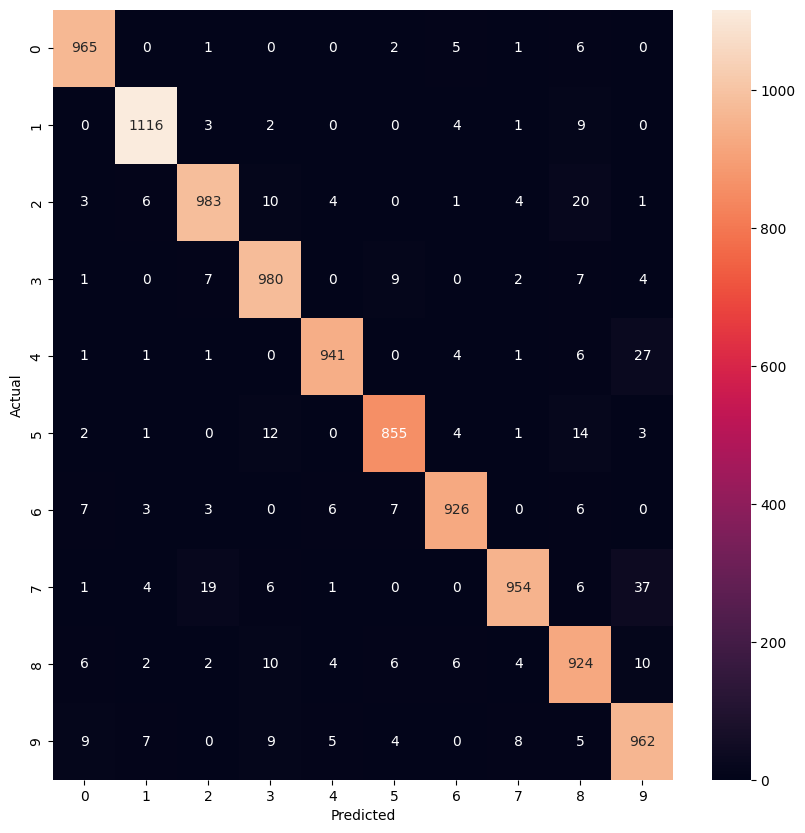

In [18]:
display_confusion_matrix(control_model, test_loader)

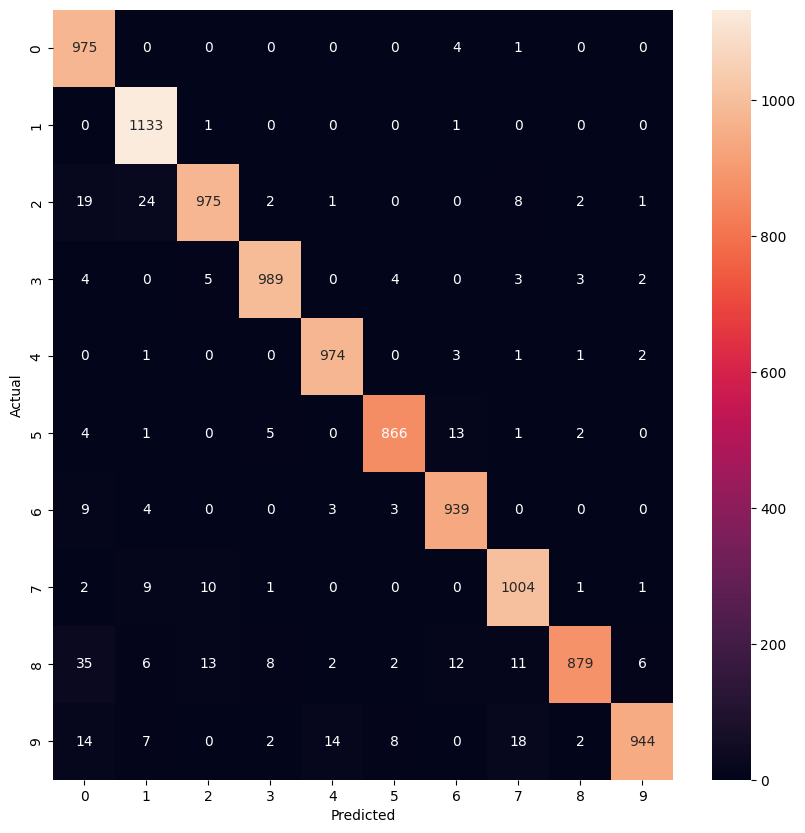

In [19]:
display_confusion_matrix(cosgd_model, test_loader)

## statistical experimental phase

In [20]:
#in 20 independent runs, train the model and store the accuracy of each epoch in a list
control_accuracies = []
cosgd_accuracies = []
for _ in range(20):
    print(f"Run {_ + 1}")
    print("Control Model")
    control_model = CNNModel()
    control_optimizer = optim.SGD(control_model.parameters(), lr=0.01)
    control_criterion = nn.CrossEntropyLoss()
    control_accuracies.append(train_model(control_model, train_loader, control_criterion, control_optimizer, epochs))
    print("COSGD Model")
    cosgd_model = CNNModel()
    cosgd_optimizer = optim.SGD(cosgd_model.parameters(), lr=0.01)
    cosgd_criterion = nn.CrossEntropyLoss()
    cosgd_accuracies.append(train_model_cosgd(cosgd_model, cosgd_optimizer, cosgd_criterion, cluster_dataloaders, epochs))

#plot the accuracy of the control model and the COSGD model for each epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), np.mean(control_accuracies, axis=0), label='Control Model')
plt.plot(range(1, epochs + 1), np.mean(cosgd_accuracies, axis=0), label='COSGD Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

#calculate the mean and standard deviation of the accuracy of the control model and the COSGD model for each epoch
control_mean = np.mean(control_accuracies, axis=0)
control_std = np.std(control_accuracies, axis=0)
cosgd_mean = np.mean(cosgd_accuracies, axis=0)
cosgd_std = np.std(cosgd_accuracies, axis=0)

#plot the mean accuracy of the control model and the COSGD model for each epoch
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, epochs + 1), control_mean, yerr=control_std, label='Control Model', capsize=5)
plt.errorbar(range(1, epochs + 1), cosgd_mean, yerr=cosgd_std, label='COSGD Model', capsize=5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()



breaking after 200 batches - next epoch
Training on Epoch [1/20], Loss: 0.7694
Accuracy of the model on the test images: 10.28%
breaking after 200 batches - next epoch
Training on Epoch [2/20], Loss: 0.7656
Accuracy of the model on the test images: 15.25%
breaking after 200 batches - next epoch
Training on Epoch [3/20], Loss: 0.7607
Accuracy of the model on the test images: 12.53%
breaking after 200 batches - next epoch
Training on Epoch [4/20], Loss: 0.7426
Accuracy of the model on the test images: 36.38%
breaking after 200 batches - next epoch
Training on Epoch [5/20], Loss: 0.5886
Accuracy of the model on the test images: 71.72%
breaking after 200 batches - next epoch
Training on Epoch [6/20], Loss: 0.2654
Accuracy of the model on the test images: 85.64%
breaking after 200 batches - next epoch
Training on Epoch [7/20], Loss: 0.1649
Accuracy of the model on the test images: 89.30%
breaking after 200 batches - next epoch
Training on Epoch [8/20], Loss: 0.1270
Accuracy of the model on 

KeyboardInterrupt: 